<img src="./images/logo.png" alt="Drawing" style="width: 500px;"/>

# **Exercise 1:** Prepare the Data

In this exercise, we will walk through deploying a PostgreSQL database in a Kubernetes environment using Python. This process will involve using Kubernetes ```kubectl``` commands to manage persistent storage (Persistent Volume Claims), deployments, services, and initialization of sample data.

You will:
- Automate the deployment of PostgreSQL on Kubernetes.
- Handle resource management like Persistent Volume Claims (PVC) and deployments.
- Set up a PostgreSQL database, create tables, and load sample data.
- Implement retry logic for connecting to PostgreSQL and ensure a robust setup.

**Steps Overview:**
- Step 1: Define functions to interact with Kubernetes resources like PVCs, deployments, and services.
- Step 2: Set up PostgreSQL on Kubernetes with proper permission handling.
- Step 3: Write code to initialize the database by creating tables and loading sample data.
- Step 4: Use Python's psycopg2 library to connect and interact with the PostgreSQL database.
- Step 5: Generate and load realistic sample data into PostgreSQL for use in subsequent analysis.

### **Prerequisites:**

As instructed in the [Introductory notebook](./00.introduction.ipynb), ensure that you have run `pip install -r requirements.txt` in a Terminal window, located in the same working directory, prior to running this notebook. 

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## **1. Prepare the environment**

<div class="alert alert-block alert-danger">
    <b>Important:</b> Set your <b>Username</b> here !
</div>

In [5]:
USERNAME="vince"

We start by defining a function to read the Kubernetes namespace from the service account mount point, allowing us to deploy resources in the correct namespace. If not running in a Kubernetes environment, it defaults to the "default" namespace.

In [6]:
def get_namespace_from_service_account():
    """
    Reads the Kubernetes namespace from the service account mount point.
    Returns 'default' if not running in a Kubernetes pod or if the file doesn't exist.
    """
    namespace_file = '/var/run/secrets/kubernetes.io/serviceaccount/namespace'
    try:
        with open(namespace_file, 'r') as f:
            return f.read().strip()
    except IOError:
        return 'default'

Set the Global variables required to run the exercise smootly

In [7]:
# Global configuration
NAMESPACE = get_namespace_from_service_account()
POSTGRES_PASSWORD = "postgres"
PG_SERVICE_NAME = f"{USERNAME}-retailers-postgres"
PG_DATABASE_NAME = f"{USERNAME}-retailers"

# Print the result
print("NAMESPACE:", NAMESPACE)
print("POSTGRES_PASSWORD:", POSTGRES_PASSWORD)
print("PG_SERVICE_NAME:", PG_SERVICE_NAME)
print("PG_DATABASE_NAME:", PG_DATABASE_NAME)

NAMESPACE: admin-901d042c
POSTGRES_PASSWORD: postgres
PG_SERVICE_NAME: vince-retailers-postgres
PG_DATABASE_NAME: vince-retailers


## **2. PostgreSQL Deployment Logic:**

We deploy PostgreSQL on Kubernetes by using Python's `subprocess` to execute `kubectl` commands. <br>
This ensures the deployment is automated, and the correct Persistent Volume Claim (PVC) and deployment configuration are applied.

In [42]:
import subprocess
import time
from datetime import datetime
import psycopg2
import random
from datetime import datetime, timedelta

Get the PostgreSQL pod name.

In [9]:
def get_pod_name(namespace, service_name):
    """Get the PostgreSQL pod name"""
    cmd = f"kubectl get pods -n {namespace} -l app={service_name} -o jsonpath='{{.items[0].metadata.name}}'"
    try:
        return subprocess.run(
            cmd, shell=True, check=True, capture_output=True, text=True
        ).stdout.strip("'")
    except subprocess.CalledProcessError:
        return None

Check if a Kubernetes resource exists.

In [10]:
def resource_exists(resource_type, name, namespace):
    """Check if a Kubernetes resource exists"""
    cmd = f"kubectl get {resource_type} {name} -n {namespace} --ignore-not-found --no-headers"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    return bool(result.stdout.strip())

Deletes an existing PostgreSQL deployment if it exists in the specified namespace.

In [11]:
def delete_existing_deployment(namespace, pg_service_name):
    """Delete any existing PostgreSQL deployment if present."""
    try:
        subprocess.run(
            f"kubectl delete deployment -n {namespace} {pg_service_name} --ignore-not-found",
            shell=True, check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Warning: Could not delete existing deployment (may not have permissions): {e}")

Creates a Persistent Volume Claim with a unique name in the specified namespace if it doesn't already exist.

In [24]:
def create_pvc(namespace, pvc_name):
    """Create Persistent Volume Claim if it doesn't exist."""
    if not resource_exists("pvc", pvc_name, namespace):
        try:
            pvc = f"""
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: {pvc_name}
  namespace: {namespace}
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 1Gi
            """
            subprocess.run(f"echo '{pvc}' | kubectl apply -f -", shell=True, check=True)
            print(f"Created new PVC: {pvc_name}")
        except subprocess.CalledProcessError as e:
            print(f"Error creating PVC with unique name, trying default name: {e}")
            pvc_name = "postgres-pvc"
            if not resource_exists("pvc", pvc_name, namespace):
                pvc = f"""
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: {pvc_name}
  namespace: {namespace}
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 1Gi
                    """
                subprocess.run(f"echo '{pvc}' | kubectl apply -f -", shell=True, check=True)
    else:
        print(f"Using existing PVC: {pvc_name}")
    return pvc_name

Creates a PostgreSQL deployment using the specified parameters and attaches the PVC for storage.

In [25]:
def create_postgresql_deployment(namespace, pg_service_name, pvc_name, postgres_password, pg_database_name):
    """Create the PostgreSQL deployment."""
    deployment = f"""
apiVersion: apps/v1
kind: Deployment
metadata:
  name: {pg_service_name}
  namespace: {namespace}
  labels:
    app: {pg_service_name}
spec:
  replicas: 1
  selector:
    matchLabels:
      app: {pg_service_name}
  template:
    metadata:
      labels:
        app: {pg_service_name}
      annotations:
        sidecar.istio.io/inject: "false"
    spec:
      securityContext:
        fsGroup: 999
        runAsUser: 999
        runAsGroup: 999
      containers:
      - name: postgres
        image: postgres:13
        env:
        - name: POSTGRES_PASSWORD
          value: "{postgres_password}"
        - name: POSTGRES_DB
          value: "{pg_database_name}"
        - name: PGDATA
          value: "/var/lib/postgresql/data/pgdata"
        ports:
        - containerPort: 5432
        volumeMounts:
        - name: postgres-data
          mountPath: /var/lib/postgresql/data
          subPath: postgres
        resources:
          requests:
            memory: "512Mi"
            cpu: "500m"
          limits:
            memory: "1Gi"
            cpu: "1"
        readinessProbe:
          exec:
            command:
            - pg_isready
            - -U
            - postgres
          initialDelaySeconds: 5
          periodSeconds: 5
        livenessProbe:
          exec:
            command:
            - pg_isready
            - -U
            - postgres
          initialDelaySeconds: 30
          periodSeconds: 10
      volumes:
      - name: postgres-data
        persistentVolumeClaim:
          claimName: {pvc_name}
        """
    subprocess.run(f"echo '{deployment}' | kubectl apply -f -", shell=True, check=True)

Creates a PostgreSQL service in the specified namespace if it doesn't already exist.

In [26]:
def create_service_if_not_exists(namespace, pg_service_name):
    """Create the PostgreSQL service if it doesn't exist."""
    if not resource_exists("service", pg_service_name, namespace):
        service = f"""
apiVersion: v1
kind: Service
metadata:
  name: {pg_service_name}
  namespace: {namespace}
spec:
  selector:
    app: {pg_service_name}
  ports:
    - protocol: TCP
      port: 5432
      targetPort: 5432
  type: ClusterIP
            """
        subprocess.run(f"echo '{service}' | kubectl apply -f -", shell=True, check=True)

Checks the status and logs of the PostgreSQL pod to ensure it is running correctly.

In [27]:
def check_postgresql_status(namespace, pg_service_name):
    """Check the status of the PostgreSQL pod."""
    pod_name = get_pod_name(namespace, pg_service_name)
    if pod_name:
        print(f"\nPostgreSQL pod: {pod_name}")
        print("\nPod status:")
        subprocess.run(f"kubectl get pod -n {namespace} {pod_name}", shell=True)
        
        print("\nPod logs:")
        subprocess.run(f"kubectl logs -n {namespace} {pod_name}", shell=True)
    else:
        print("Could not find PostgreSQL pod")

Deploy PostgreSQL with proper permission handling and PVC management.

In [28]:
def deploy_postgresql():
    """Deploy PostgreSQL with proper permission handling and PVC management"""
    pvc_name = f"postgres-pvc-{datetime.now().strftime('%Y%m%d%H%M%S')}"
    
    # Delete any existing deployment
    delete_existing_deployment(NAMESPACE, PG_SERVICE_NAME)
    
    # Create PVC
    pvc_name = create_pvc(NAMESPACE, pvc_name)
    
    # Create Deployment
    create_postgresql_deployment(NAMESPACE, PG_SERVICE_NAME, pvc_name, POSTGRES_PASSWORD, PG_DATABASE_NAME)
    
    # Create Service if necessary
    create_service_if_not_exists(NAMESPACE, PG_SERVICE_NAME)
    
    # Wait for PostgreSQL to initialize
    print("Waiting for PostgreSQL to initialize...")
    time.sleep(30)
    
    # Check the status of the PostgreSQL pod
    check_postgresql_status(NAMESPACE, PG_SERVICE_NAME)

Run the deployment

In [29]:
# Run the deployment
deploy_postgresql()

deployment.apps "vince-retailers-postgres" deleted
persistentvolumeclaim/postgres-pvc-20250409104337 created
Created new PVC: postgres-pvc-20250409104337
deployment.apps/vince-retailers-postgres created
Waiting for PostgreSQL to initialize...

PostgreSQL pod: vince-retailers-postgres-7c9756cbfb-wcpgt

Pod status:
NAME                                        READY   STATUS    RESTARTS   AGE
vince-retailers-postgres-7c9756cbfb-wcpgt   1/1     Running   0          30s

Pod logs:
chmod: changing permissions of '/var/run/postgresql': Operation not permitted
The files belonging to this database system will be owned by user "postgres".
This user must also own the server process.

The database cluster will be initialized with locale "en_US.utf8".
The default database encoding has accordingly been set to "UTF8".
The default text search configuration will be set to "english".

Data page checksums are disabled.

fixing permissions on existing directory /var/lib/postgresql/data/pgdata ... ok
creati

## **4. Database Connection and Retry Logic:**

To interact with the PostgreSQL database, we use `psycopg2` to connect to the database. <br>
We implement retry logic in case the database is not yet available after the deployment.

In [34]:
def get_db_connection(retries=3, delay=5):
    """Get connection with retries"""
    for attempt in range(retries):
        try:
            conn = psycopg2.connect(
                host=f"{PG_SERVICE_NAME}.{NAMESPACE}.svc.cluster.local",
                database=PG_DATABASE_NAME,
                user="postgres",
                password=POSTGRES_PASSWORD,
                port="5432",
                connect_timeout=5
            )
            return conn
        except psycopg2.OperationalError as e:
            if attempt == retries - 1:
                raise
            print(f"Connection failed (attempt {attempt + 1}), retrying...")
            time.sleep(delay)
        except Exception as e:
            print(f"Unexpected error during connection: {e}")
            raise

## **5. Initialize Database & Generate Sample Data:**

Initializes the database by creating tables and loading sample data into the PostgreSQL database.

In [35]:
def initialize_database():
    """Create tables and load sample data"""
    conn = None
    cursor = None
    try:
        print("Initializing database...")
        
        # 1. Create tables
        print("Creating tables...")
        conn = get_db_connection()
        cursor = conn.cursor()
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS source_catalog (
            product_id INT PRIMARY KEY,
            product_name VARCHAR(100),
            product_category VARCHAR(50),
            price_cents INT
        );''')
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS source_customers (
            customer_id INT PRIMARY KEY,
            customer_name VARCHAR(50),
            customer_surname VARCHAR(50),
            customer_email VARCHAR(100)
        );''')
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS source_stock (
            entry_id INT PRIMARY KEY,
            product_id INT REFERENCES source_catalog(product_id),
            product_quantity INT,
            purchase_price_cents INT,
            entry_date DATE
        );''')
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS source_orders (
            order_id INT PRIMARY KEY,
            customer_id INT REFERENCES source_customers(customer_id),
            order_status VARCHAR(20),
            order_date DATE
        );''')
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS source_order_products (
            transaction_id INT PRIMARY KEY,
            order_id INT REFERENCES source_orders(order_id),
            product_id INT REFERENCES source_catalog(product_id),
            product_quantity INT
        );''')
        
        conn.commit()
        print("Tables created successfully")
        
        # 2. Load sample data
        print("Loading sample data...")
        data = generate_sample_data()
        
        # Load products
        for p in data["products"]:
            cursor.execute('''
                INSERT INTO source_catalog VALUES (%s, %s, %s, %s)
                ON CONFLICT (product_id) DO NOTHING
            ''', (p["product_id"], p["product_name"], p["product_category"], p["price_cents"]))
        
        # Load customers
        for c in data["customers"]:
            cursor.execute('''
                INSERT INTO source_customers VALUES (%s, %s, %s, %s)
                ON CONFLICT (customer_id) DO NOTHING
            ''', (c["customer_id"], c["customer_name"], c["customer_surname"], c["customer_email"]))
        
        # Load stock
        for s in data["stock"]:
            cursor.execute('''
                INSERT INTO source_stock VALUES (%s, %s, %s, %s, %s)
                ON CONFLICT (entry_id) DO NOTHING
            ''', (s["entry_id"], s["product_id"], s["product_quantity"], s["purchase_price_cents"], s["entry_date"]))
        
        # Load orders
        for o in data["orders"]:
            cursor.execute('''
                INSERT INTO source_orders VALUES (%s, %s, %s, %s)
                ON CONFLICT (order_id) DO NOTHING
            ''', (o["order_id"], o["customer_id"], o["order_status"], o["order_date"]))
        
        # Load order products
        for op in data["order_products"]:
            cursor.execute('''
                INSERT INTO source_order_products VALUES (%s, %s, %s, %s)
                ON CONFLICT (transaction_id) DO NOTHING
            ''', (op["transaction_id"], op["order_id"], op["product_id"], op["product_quantity"]))
        
        conn.commit()
        print("Sample data loaded successfully")
        
    except Exception as e:
        if conn is not None:
            conn.rollback()
        print(f"Error during initialization: {e}")
        raise
    finally:
        if cursor is not None:
            cursor.close()
        if conn is not None:
            conn.close()

The `generate_sample_data` function simulates realistic product, customer, stock, and order data with controlled imperfections. <br>
It includes deliberate imperfections (e.g., missing emails, invalid product categories) <br>
The returned data is structured in a way that makes it easy to insert into the database.<br>
This data can be used for testing and analysis within the PostgreSQL database.

In [36]:
# Generate sample data function (same as before)
def generate_sample_data():
    """Generate realistic sample data with controlled imperfections"""
    categories = ["Toys", "Clothing", "Books", "Electronics", "Home Decor", "Toyz", "Clothng", "Eletronics"]
    first_names = ["Emma", "Liam", "Olivia", "Noah", "Ava", None, " "]
    last_names = ["Smith", "Johnson", "Williams", "Brown", "Jones", "De'Lacey", "O'Brien", "Van Helsing"]
    statuses = ["completed", "pending", "cancelled", "shipped", "in progress", "done"]
    
    def get_email_part(part):
        if part is None:
            return "unknown"
        part = str(part).strip()
        return part.lower() if part else "unknown"
    
    # Products - with some imperfections
    products = []
    for i in range(1, 101):
        if random.random() > 0.95 and i > 1:
            continue
            
        if random.random() > 0.98 and i > 1:
            products.append({
                "product_id": i-1,
                "product_name": f"Duplicate {random.choice([c for c in categories if c])[:-1]} {i}",
                "product_category": random.choice(categories),
                "price_cents": random.randint(500, 10000)
            })
        
        product_name = f"{random.choice([c for c in categories if c])[:-1]} {i}" if random.random() > 0.1 else None
        product_category = random.choice(categories) if random.random() > 0.1 else None
        price_cents = random.randint(500, 10000) if random.random() > 0.05 else None
            
        products.append({
            "product_id": i,
            "product_name": product_name,
            "product_category": product_category,
            "price_cents": price_cents
        })
    
    # Customers - with some imperfections
    customers = []
    for i in range(1, 51):
        first_part = random.choice(first_names)
        last_part = random.choice(last_names)
        email = f"{get_email_part(first_part)}.{get_email_part(last_part)}@example.com"
        
        if random.random() > 0.9:
            email = "invalid.email"
        if random.random() > 0.95:
            email = None
            
        name = random.choice(first_names) if random.random() > 0.1 else None
        surname = random.choice(last_names) if random.random() > 0.1 else None
        
        customers.append({
            "customer_id": i,
            "customer_name": name,
            "customer_surname": surname,
            "customer_email": email
        })
    
    # Stock - with some imperfections
    stock = []
    entry_id = 1
    for product in products:
        if random.random() > 0.05:
            for _ in range(random.randint(1, 3)):
                quantity = random.randint(10, 100)
                if random.random() > 0.95:
                    quantity = -quantity
                    
                days_ago = random.randint(1, 365)
                if random.random() > 0.9:
                    days_ago = random.randint(1000, 2000)
                
                purchase_price = int(product["price_cents"] * 0.7) if product.get("price_cents") else None
                
                if random.random() > 0.95:
                    entry_date = None
                else:
                    entry_date = (datetime.now() - timedelta(days=days_ago)).date()
                
                stock.append({
                    "entry_id": entry_id,
                    "product_id": product["product_id"],
                    "product_quantity": quantity if random.random() > 0.95 else None,
                    "purchase_price_cents": purchase_price,
                    "entry_date": entry_date
                })
                entry_id += 1
    
    # Orders - with controlled imperfections
    orders = []
    valid_customer_ids = [c["customer_id"] for c in customers]
    for i in range(1, 201):
        if random.random() > 0.95:
            customer_id = None  # NULL if allowed by schema
        else:
            customer_id = random.choice(valid_customer_ids)
            
        if random.random() > 0.95:
            order_date = None
        elif random.random() > 0.98:
            order_date = (datetime.now() + timedelta(days=random.randint(1000, 2000))).date()
        else:
            order_date = (datetime.now() - timedelta(days=random.randint(1, 90))).date()
            
        orders.append({
            "order_id": i,
            "customer_id": customer_id,
            "order_status": random.choice(statuses),
            "order_date": order_date
        })
    
    # Order Products - Now only using valid product IDs
    order_products = []
    valid_product_ids = [p["product_id"] for p in products]
    transaction_id = 1
    for order in orders:
        for _ in range(random.randint(1, 5)):
            # Always use valid product IDs
            product_id = random.choice(valid_product_ids)
            
            quantity = random.randint(1, 3)
            if random.random() > 0.97:
                quantity = -quantity
                
            order_products.append({
                "transaction_id": transaction_id,
                "order_id": order["order_id"],
                "product_id": product_id,
                "product_quantity": quantity if random.random() > 0.95 else None
            })
            transaction_id += 1
    
    return {
        "products": products,
        "customers": customers,
        "stock": stock,
        "orders": orders,
        "order_products": order_products
    }

Run initialization

In [43]:
# Run initialization separately
initialize_database()

Initializing database...
Creating tables...
Tables created successfully
Loading sample data...
Sample data loaded successfully


## Verifying the data

In [44]:
def verify_data():
    """Verify data exists by querying each table"""
    try:
        conn = get_db_connection()
        cursor = conn.cursor()
        
        print("\nVerifying data...")
        
        # Check products
        cursor.execute("SELECT COUNT(*) FROM source_catalog")
        product_count = cursor.fetchone()[0]
        print(f"Products: {product_count} records")
        
        # Check customers
        cursor.execute("SELECT COUNT(*) FROM source_customers")
        customer_count = cursor.fetchone()[0]
        print(f"Customers: {customer_count} records")
        
        # Check stock
        cursor.execute("SELECT COUNT(*) FROM source_stock")
        stock_count = cursor.fetchone()[0]
        print(f"Stock entries: {stock_count} records")
        
        # Check orders
        cursor.execute("SELECT COUNT(*) FROM source_orders")
        order_count = cursor.fetchone()[0]
        print(f"Orders: {order_count} records")
        
        # Check order products
        cursor.execute("SELECT COUNT(*) FROM source_order_products")
        transaction_count = cursor.fetchone()[0]
        print(f"Order products: {transaction_count} records")
        
        # Sample some data
        print("\nSample product:")
        cursor.execute("SELECT * FROM source_catalog LIMIT 1")
        print(cursor.fetchone())
        
        print("\nSample customer:")
        cursor.execute("SELECT * FROM source_customers LIMIT 1")
        print(cursor.fetchone())
        
    except Exception as e:
        print(f"Error verifying data: {e}")
    finally:
        cursor.close()
        conn.close()

# Run verification
verify_data()


Verifying data...
Products: 93 records
Customers: 50 records
Stock entries: 183 records
Orders: 200 records
Order products: 597 records

Sample product:
(1, 'Electronic 1', 'Books', 3980)

Sample customer:
(1, 'Noah', 'Brown', 'unknown.van helsing@example.com')


## Visualize the data

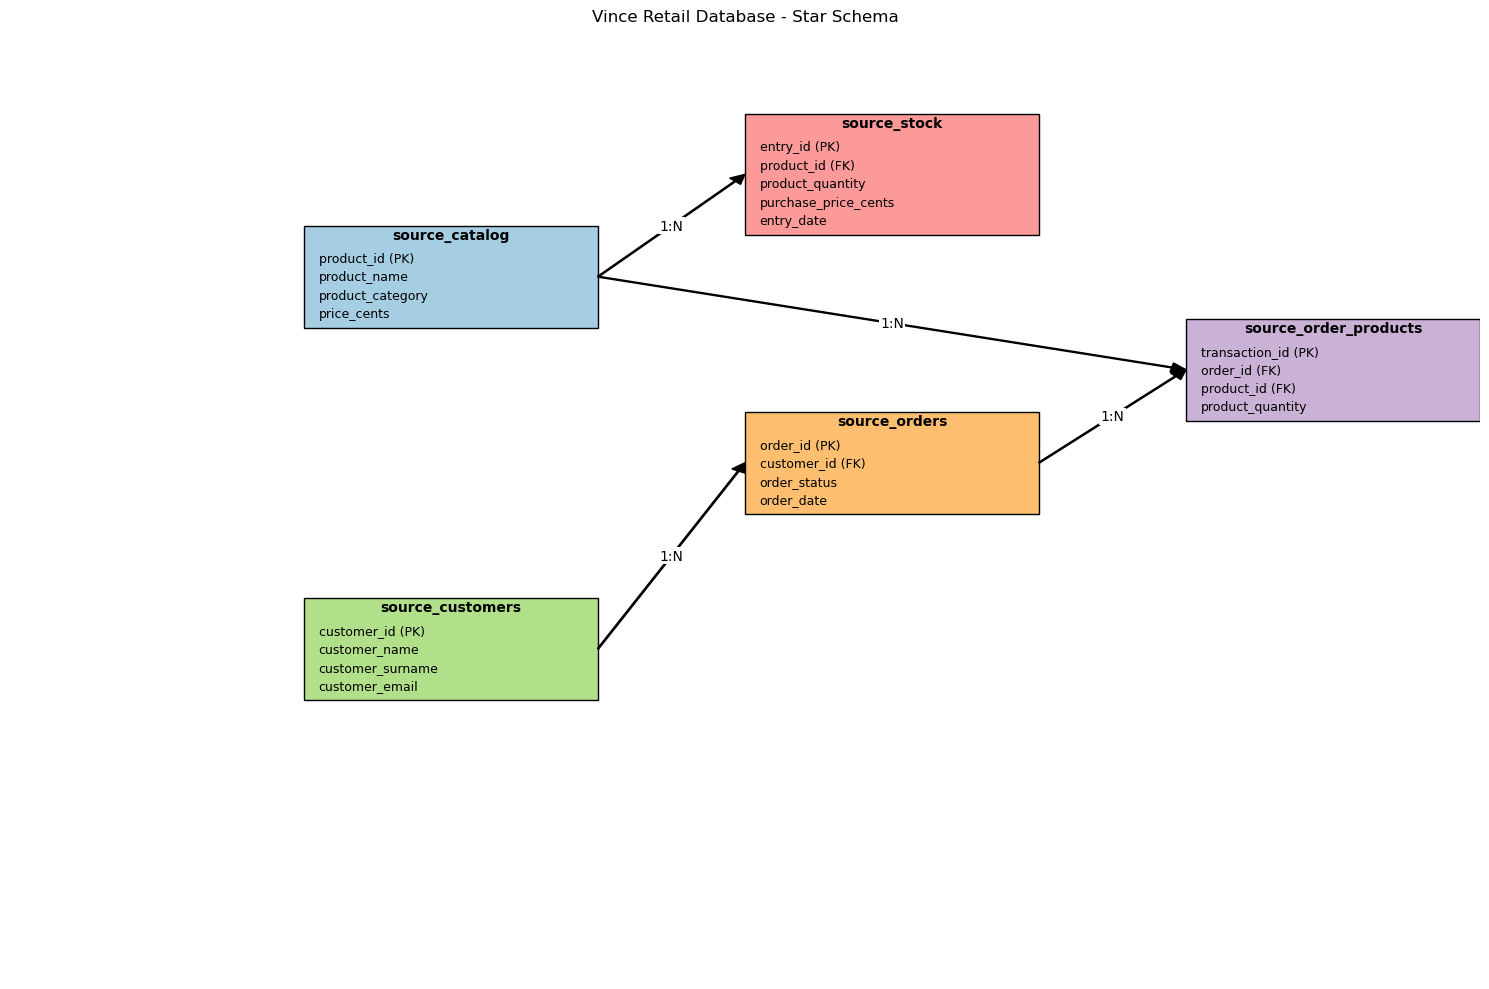

In [45]:
import psycopg2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
import matplotlib.patches as patches

def draw_star_schema_matplotlib():
    """Draw star schema using matplotlib (no Graphviz required)"""
    try:
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        
        # Table definitions
        tables = {
            'source_catalog': {
                'position': (2, 7),
                'columns': ['product_id (PK)', 'product_name', 'product_category', 'price_cents'],
                'color': '#a6cee3'
            },
            'source_customers': {
                'position': (2, 3),
                'columns': ['customer_id (PK)', 'customer_name', 'customer_surname', 'customer_email'],
                'color': '#b2df8a'
            },
            'source_stock': {
                'position': (5, 8),
                'columns': ['entry_id (PK)', 'product_id (FK)', 'product_quantity', 'purchase_price_cents', 'entry_date'],
                'color': '#fb9a99'
            },
            'source_orders': {
                'position': (5, 5),
                'columns': ['order_id (PK)', 'customer_id (FK)', 'order_status', 'order_date'],
                'color': '#fdbf6f'
            },
            'source_order_products': {
                'position': (8, 6),
                'columns': ['transaction_id (PK)', 'order_id (FK)', 'product_id (FK)', 'product_quantity'],
                'color': '#cab2d6'
            }
        }
        
        # Draw tables
        for table, props in tables.items():
            x, y = props['position']
            
            # Draw table box
            table_box = Rectangle((x, y), 2, 0.3 + 0.2 * len(props['columns']), 
                                facecolor=props['color'], edgecolor='black')
            ax.add_patch(table_box)
            
            # Add table name
            ax.text(x + 1, y + 0.2 + 0.2 * len(props['columns']), table, 
                   ha='center', va='center', weight='bold')
            
            # Add columns
            for i, col in enumerate(props['columns']):
                ax.text(x + 0.1, y + 0.15 + 0.2 * (len(props['columns']) - i - 1), 
                       col, ha='left', va='center', fontsize=9)
        
        # Draw relationships
        relationships = [
            ('source_catalog', 'source_stock', '1:N'),
            ('source_catalog', 'source_order_products', '1:N'),
            ('source_customers', 'source_orders', '1:N'),
            ('source_orders', 'source_order_products', '1:N')
        ]
        
        for src, dst, label in relationships:
            src_x = tables[src]['position'][0] + 2
            src_y = tables[src]['position'][1] + (0.3 + 0.2 * len(tables[src]['columns'])) / 2
            dst_x = tables[dst]['position'][0]
            dst_y = tables[dst]['position'][1] + (0.3 + 0.2 * len(tables[dst]['columns'])) / 2
            
            arrow = FancyArrow(src_x, src_y, dst_x - src_x, dst_y - src_y, 
                              width=0.01, head_width=0.1, head_length=0.1, 
                              length_includes_head=True, color='black')
            ax.add_patch(arrow)
            
            # Add relationship label
            label_x = (src_x + dst_x) / 2
            label_y = (src_y + dst_y) / 2
            ax.text(label_x, label_y, label, ha='center', va='center', 
                   bbox=dict(facecolor='white', edgecolor='none', pad=1))
        
        plt.title('Vince Retail Database - Star Schema', pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating diagram: {e}")

# Generate and display the diagram
draw_star_schema_matplotlib()

# **Conclusion**

By following these steps, you'll deploy a PostgreSQL database to a Kubernetes cluster, initialize it with tables, and load sample data for analysis. 

This exercise helps you become familiar with automating Kubernetes deployments using Python, handling PostgreSQL databases, and generating and loading data for testing purposes.

In the next exercise, you will learn how to use Spark on **HPE AI Essentials** to prepare these datasets for visualization and modelling. 

Next: <a href="./02.query_with_ezpresto" style="color: black"><b style="color: #01a982;">Exercise 2:</b> Connect and Query Data Sources with EzPresto</a>
